In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, trange

from dataset import Dataset, get_transac_sec
from models import Classifier, Projector
from trainers.drocc_trainer import DROCCTrainer, adjust_learning_rate
from trainers.dsvdd_trainer import DeepSVDD

In [5]:
# df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df = pd.read_csv('creditcard.csv')
df.head()

DEVICE="mps"

In [6]:
normal_rate = len(df[df['Class']==0])/ len(df)
anormal_rate = len(df[df['Class']==1])/ len(df)

print(f"normal rate: {normal_rate} ; anormal rate: {anormal_rate}")

normal rate: 0.9982725143693799 ; anormal rate: 0.001727485630620034


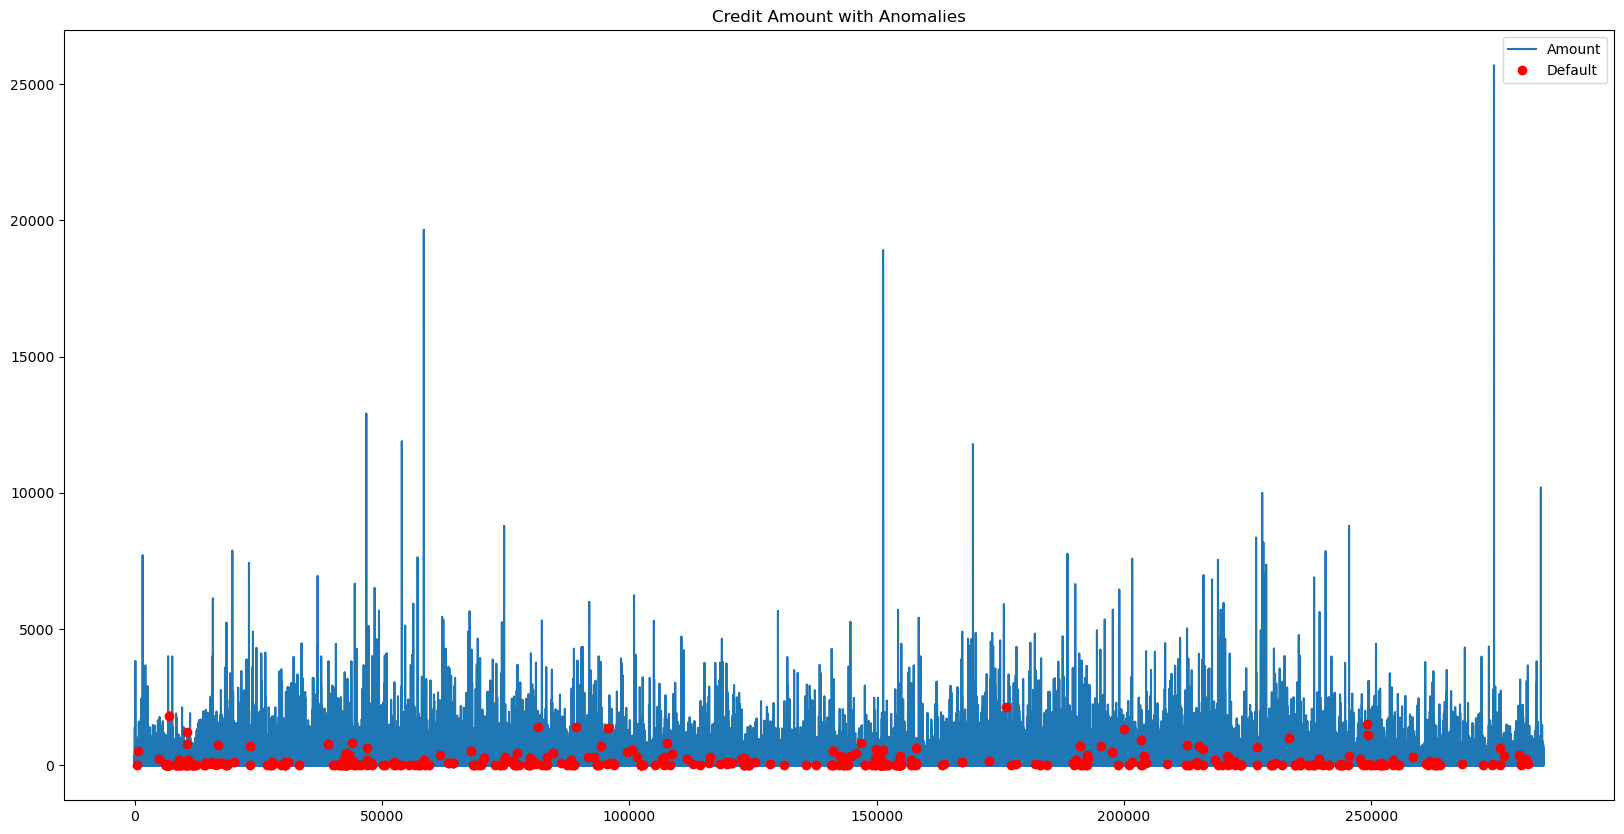

In [7]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value, label='Amount')
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label='Default')
plt.title('Credit Amount with Anomalies')
plt.legend()

# Supervised Setting

In [13]:
dataset = get_transac_sec(df)

train_size = int(0.6*len(dataset))

train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]

scaler = StandardScaler()

train = train.copy()
test = test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

### Basic DNN Classifier

In [14]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3

In [15]:
trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = Classifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [16]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 4.066315390348078e-06


epoch loss : 1.6803237676486641e-06


In [17]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        preds = torch.sigmoid(preds)
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:01<00:00, 256.38it/s]

ROC-AUC score: 0.9398524820757248


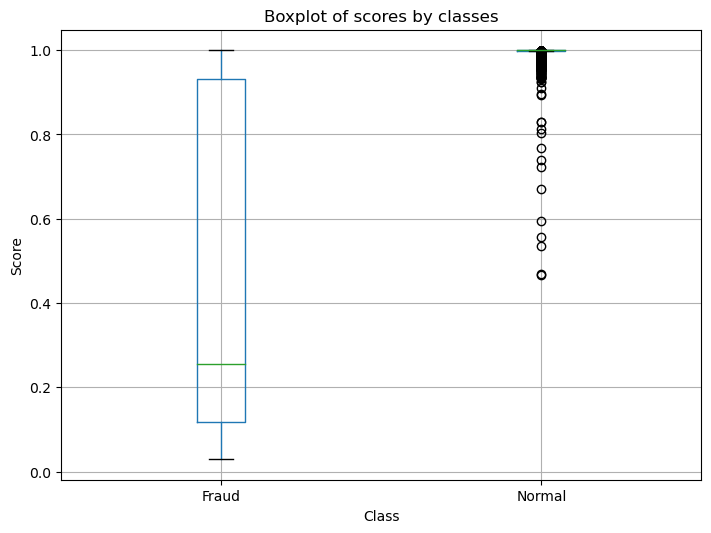

In [18]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6))

plt.title("Boxplot of scores by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

# Unsupervised Setting

In [21]:
dataset = df.copy()

train_size = int(0.6 * len(dataset))
train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]
train = train[train['Class'] == 0]

new_train_size = len(train)

dataset = pd.concat([train, test], ignore_index=True)
dataset = get_transac_sec(dataset)

train = dataset.iloc[:new_train_size]
test = dataset.iloc[new_train_size:]

scaler = StandardScaler()

train, test = train.copy(), test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

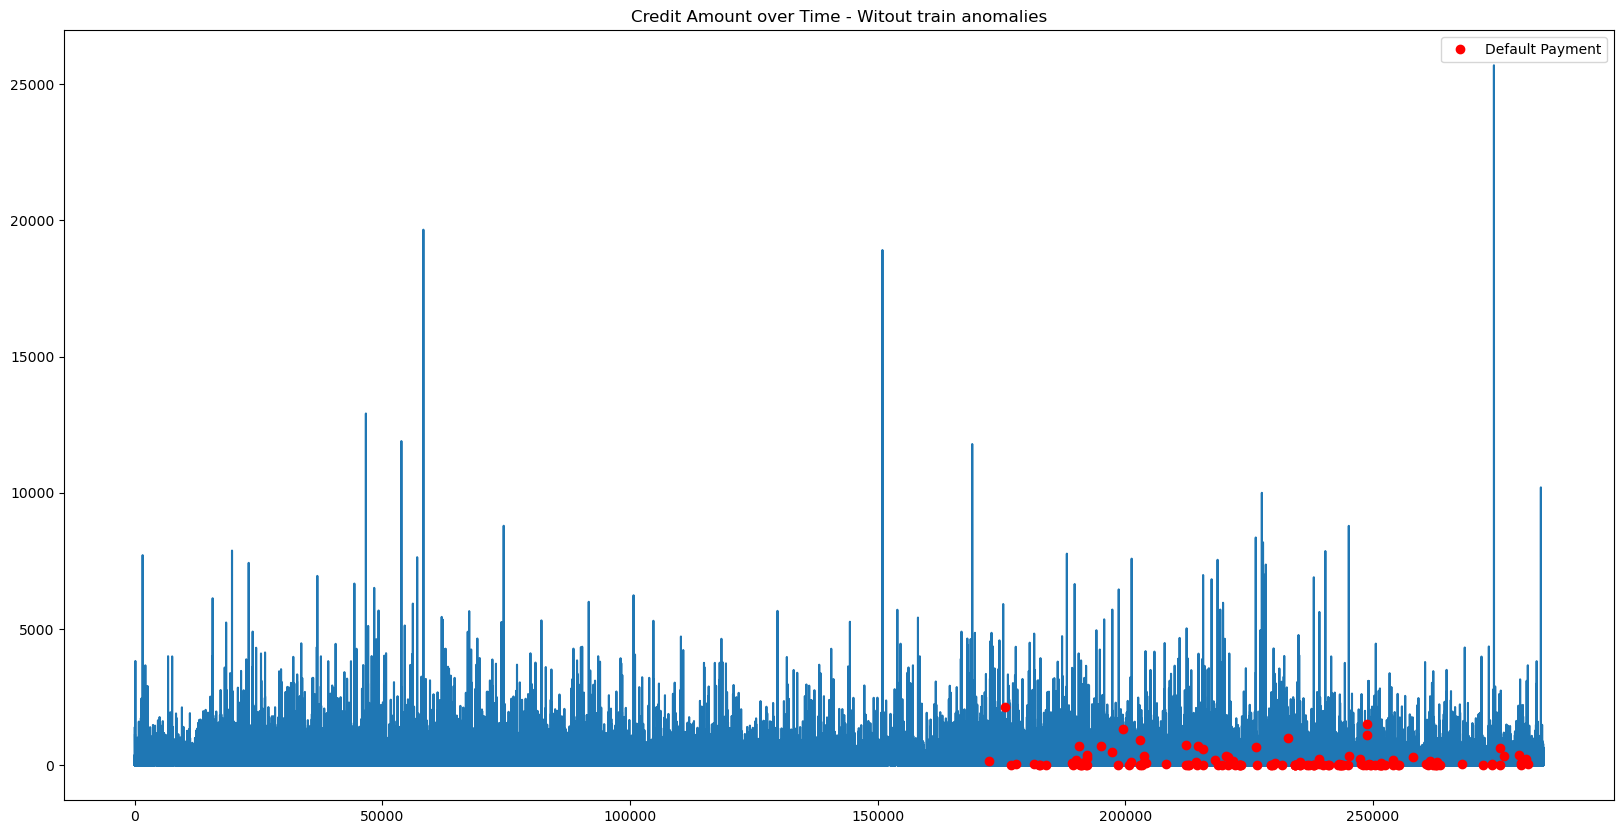

In [22]:
plt.figure(figsize=(20, 10))

value = dataset['Amount']
anomalies = dataset['Class']

indices = range(len(value))
anomalies_indices = [i for i in dataset[dataset['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

### SGD OC-SVM

In [12]:
X_train = train.drop(['Time', 'Class'], axis=1)
X_test = test.drop(['Time', 'Class'], axis=1)
y_test = test['Class']

In [13]:
clf = SGDOneClassSVM().fit(X_train)
prediction = clf.predict(X_test)

prediction = clf.predict(X_test)
prediction = np.where(prediction == -1, 1, 0)

score = roc_auc_score(y_test, prediction)
print(f"ROC-AUC score: {score}")

ROC-AUC score: 0.5702536321906483


### Deep SVDD

In [14]:
LR=1e-3
EPOCHS=10
BATCH_SIZE=256
WEIGHT_DECAY=1e-6
PROJ_DIM=32

In [20]:
model = Projector(proj_dim=PROJ_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=0.1)

In [16]:
svdd = DeepSVDD(model=model, proj_dim=PROJ_DIM, device=DEVICE)
center = svdd.initialize_center(trainloader=trainloader)
results = svdd.train(trainloader=trainloader, epochs=EPOCHS, optimizer=optimizer, scheduler=scheduler)

model = results["model"]
center = results["center"]

Training: 100%|██████████| 667/667 [00:04<00:00, 148.22it/s]


Epoch 1/10 ; Loss: 0.5542


Training: 100%|██████████| 667/667 [00:04<00:00, 134.24it/s]


Epoch 2/10 ; Loss: 0.1673


Training: 100%|██████████| 667/667 [00:04<00:00, 150.74it/s]


Epoch 3/10 ; Loss: 0.0986


Training: 100%|██████████| 667/667 [00:04<00:00, 156.32it/s]


Epoch 4/10 ; Loss: 0.0649


Training: 100%|██████████| 667/667 [00:04<00:00, 139.82it/s]


Epoch 5/10 ; Loss: 0.0445


Training: 100%|██████████| 667/667 [00:04<00:00, 147.85it/s]


Epoch 6/10 ; Loss: 0.0315


Training: 100%|██████████| 667/667 [00:04<00:00, 156.06it/s]


Epoch 7/10 ; Loss: 0.0230


Training: 100%|██████████| 667/667 [00:04<00:00, 152.77it/s]


Epoch 8/10 ; Loss: 0.0172


Training: 100%|██████████| 667/667 [00:04<00:00, 151.45it/s]


Epoch 9/10 ; Loss: 0.0132


Training: 100%|██████████| 667/667 [00:04<00:00, 154.31it/s]

Epoch 10/10 ; Loss: 0.0104


In [17]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        proj = model(test_batch)
        dist = torch.sum((proj - center) ** 2, dim=1)
        all_preds.append(-dist.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:02<00:00, 219.15it/s]


ROC-AUC score: 0.9625425720679299


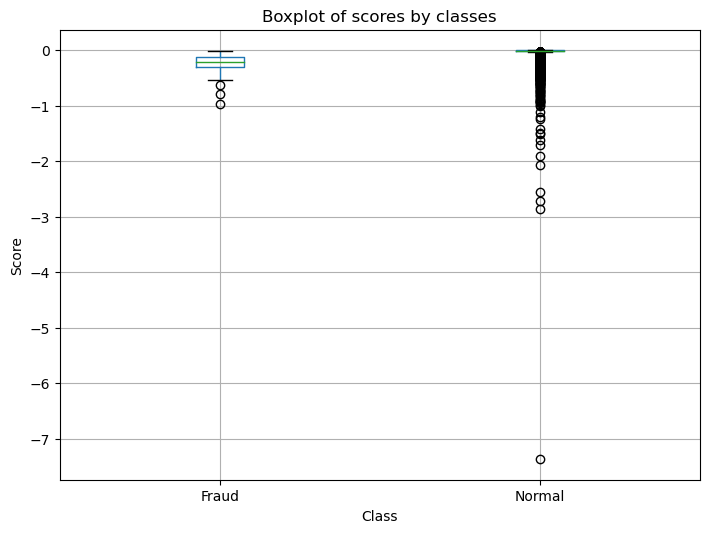

In [18]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6))

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### DROCC

In [23]:
import torch 
import torch.nn.functional as F
from tqdm import tqdm
"""
Code from the official repo: https://github.com/microsoft/EdgeML/blob/master/pytorch/edgeml_pytorch/trainer/drocc_trainer.py
"""

#trainer class for DROCC
class DROCCTrainer:
    """
    Trainer class that implements the DROCC algorithm proposed in
    https://arxiv.org/abs/2002.12718
    """

    def __init__(self, model, optimizer, lamda, radius, gamma, device):
        """Initialize the DROCC Trainer class

        Parameters
        ----------
        model: Torch neural network object
        optimizer: Total number of epochs for training.
        lamda: Weight given to the adversarial loss
        radius: Radius of hypersphere to sample points from.
        gamma: Parameter to vary projection.
        device: torch.device object for device to use.
        """     
        self.model = model
        self.optimizer = optimizer
        self.lamda = lamda
        self.radius = radius
        self.gamma = gamma
        self.device = device

    def train(self, train_loader, learning_rate, lr_scheduler, total_epochs, 
                only_ce_epochs=50, ascent_step_size=0.001, ascent_num_steps=50):
        """Trains the model on the given training dataset with periodic 
        evaluation on the validation dataset.

        Parameters
        ----------
        train_loader: Dataloader object for the training dataset.
        val_loader: Dataloader object for the validation dataset.
        learning_rate: Initial learning rate for training.
        total_epochs: Total number of epochs for training.
        only_ce_epochs: Number of epochs for initial pretraining.
        ascent_step_size: Step size for gradient ascent for adversarial 
                          generation of negative points.
        ascent_num_steps: Number of gradient ascent steps for adversarial 
                          generation of negative points.
        metric: Metric used for evaluation (AUC / F1).
        """

        self.ascent_num_steps = ascent_num_steps
        self.ascent_step_size = ascent_step_size
        for epoch in range(total_epochs): 
            #Make the weights trainable
            self.model.train()
            lr_scheduler(epoch, total_epochs, only_ce_epochs, learning_rate, self.optimizer)
            
            #Placeholder for the respective 2 loss values
            epoch_adv_loss = torch.tensor([0]).type(torch.float32).to(self.device)  #AdvLoss
            epoch_ce_loss = 0  #Cross entropy Loss
            
            batch_idx = -1
            for data, target in tqdm(train_loader):
                batch_idx += 1
                data, target = data.to(self.device), target.to(self.device)
                # Data Processing
                data = data.to(torch.float)
                target = target.to(torch.float)
                target = torch.squeeze(target)

                self.optimizer.zero_grad()
                
                # Extract the logits for cross entropy loss
                logits = self.model(data)
                logits = torch.squeeze(logits, dim = 1)
                ce_loss = F.binary_cross_entropy_with_logits(logits, target)
                # Add to the epoch variable for printing average CE Loss
                epoch_ce_loss += ce_loss

                '''
                Adversarial Loss is calculated only for the positive data points (label==1).
                '''
                if  epoch >= only_ce_epochs:
                    data = data[target == 1]
                    # AdvLoss 
                    adv_loss = self.one_class_adv_loss(data)
                    epoch_adv_loss += adv_loss

                    loss = ce_loss + adv_loss * self.lamda
                else: 
                    # If only CE based training has to be done
                    loss = ce_loss
                
                # Backprop
                loss.backward()
                self.optimizer.step()
                    
            epoch_ce_loss = epoch_ce_loss/(batch_idx + 1)  #Average CE Loss
            epoch_adv_loss = epoch_adv_loss/(batch_idx + 1) #Average AdvLoss

            print('Epoch: {}, CE Loss: {}, AdvLoss: {}'.format(
                epoch, epoch_ce_loss.item(), epoch_adv_loss.item()))   
    
    def one_class_adv_loss(self, x_train_data):
        """Computes the adversarial loss:
        1) Sample points initially at random around the positive training
            data points
        2) Gradient ascent to find the most optimal point in set N_i(r) 
            classified as +ve (label=0). This is done by maximizing 
            the CE loss wrt label 0
        3) Project the points between spheres of radius R and gamma * R 
            (set N_i(r))
        4) Pass the calculated adversarial points through the model, 
            and calculate the CE loss wrt target class 0
        
        Parameters
        ----------
        x_train_data: Batch of data to compute loss on.
        """
        batch_size = len(x_train_data)
        # Randomly sample points around the training data
        # We will perform SGD on these to find the adversarial points
        x_adv = torch.randn(x_train_data.shape).to(self.device).detach().requires_grad_()
        x_adv_sampled = x_adv + x_train_data

        for step in range(self.ascent_num_steps):
            with torch.enable_grad():

                new_targets = torch.zeros(batch_size, 1).to(self.device)
                new_targets = torch.squeeze(new_targets)
                new_targets = new_targets.to(torch.float)
                
                logits = self.model(x_adv_sampled)         
                logits = torch.squeeze(logits, dim = 1)
                new_loss = F.binary_cross_entropy_with_logits(logits, new_targets)

                grad = torch.autograd.grad(new_loss, [x_adv_sampled])[0]
                grad_norm = torch.norm(grad, p=2, dim = tuple(range(1, grad.dim())))
                grad_norm = grad_norm.view(-1, *[1]*(grad.dim()-1))
                grad_normalized = grad/grad_norm 
            with torch.no_grad():
                x_adv_sampled.add_(self.ascent_step_size * grad_normalized)

            if (step + 1) % 10==0:
                # Project the normal points to the set N_i(r)
                h = x_adv_sampled - x_train_data
                norm_h = torch.sqrt(torch.sum(h**2, 
                                                dim=tuple(range(1, h.dim()))))
                alpha = torch.clamp(norm_h, self.radius, 
                                    self.gamma * self.radius).to(self.device)
                # Make use of broadcast to project h
                proj = (alpha/norm_h).view(-1, *[1] * (h.dim()-1))
                h = proj * h
                x_adv_sampled = x_train_data + h  #These adv_points are now on the surface of hyper-sphere

        adv_pred = self.model(x_adv_sampled)
        adv_pred = torch.squeeze(adv_pred, dim=1)
        adv_loss = F.binary_cross_entropy_with_logits(adv_pred, (new_targets * 0))
        assert not torch.isnan(adv_loss), "NAN"
        return adv_loss
    
    def get_model(self):
        return self.model
    

def adjust_learning_rate(epoch, total_epochs, only_ce_epochs, learning_rate, optimizer):
        """Adjust learning rate during training.

        Parameters
        ----------
        epoch: Current training epoch.
        total_epochs: Total number of epochs for training.
        only_ce_epochs: Number of epochs for initial pretraining.
        learning_rate: Initial learning rate for training.
        """
        #We dont want to consider the only ce 
        #based epochs for the lr scheduler
        epoch = epoch - only_ce_epochs
        drocc_epochs = total_epochs - only_ce_epochs
        # lr = learning_rate
        if epoch <= drocc_epochs:
            lr = learning_rate * 0.001
        if epoch <= 0.90 * drocc_epochs:
            lr = learning_rate * 0.01  
        if epoch <= 0.60 * drocc_epochs:
            lr = learning_rate * 0.1  
        if epoch <= 0.30 * drocc_epochs:
            lr = learning_rate    
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

In [32]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=5

In [33]:
model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [34]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

model = trainer.get_model()

100%|██████████| 667/667 [00:05<00:00, 125.02it/s]


Epoch: 0, CE Loss: 0.0316091850399971, AdvLoss: 0.0


100%|██████████| 667/667 [01:36<00:00,  6.94it/s]


Epoch: 1, CE Loss: 0.7376508712768555, AdvLoss: 1.0494815111160278


100%|██████████| 667/667 [01:34<00:00,  7.04it/s]


Epoch: 2, CE Loss: 0.6995291709899902, AdvLoss: 0.6304011344909668


100%|██████████| 667/667 [01:30<00:00,  7.38it/s]

Epoch: 3, CE Loss: 0.6862546801567078, AdvLoss: 0.627924919128418


In [35]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:01<00:00, 231.39it/s]

ROC-AUC score: 0.9584483767822081


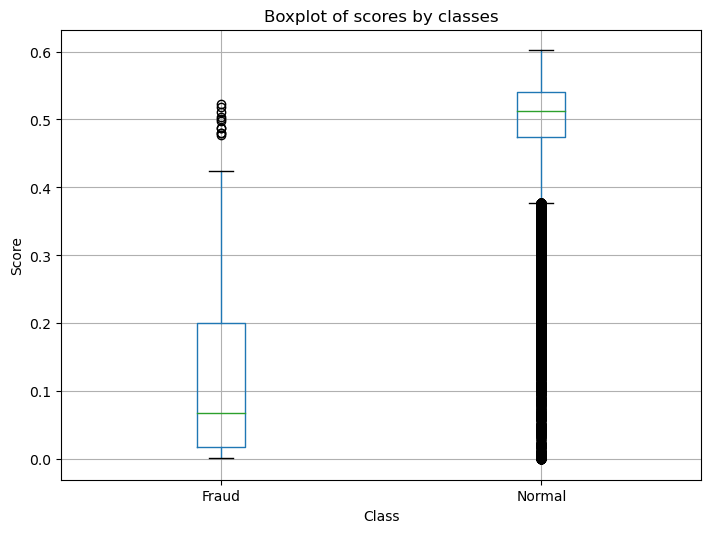

In [36]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6))

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()